다음의 캐글 노트북을 필사했습니다.

https://www.kaggle.com/gpreda/porto-seguro-exploratory-analysis-and-prediction

## Import packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 100)

## Load the data

In [3]:
trainset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle study/Porto Seguro’s Safe Driver Prediction/data/train.csv')
testset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle study/Porto Seguro’s Safe Driver Prediction/data/test.csv')

## Few quick observations

대회의 data description을 기초로 몇 가지 빠른 관측을 할 수 있습니다.  
  
* 소수의 그룹이 정의됐으며 이러한 그룹에 속한 피처들은 이름에 패턴이 포함됐습니다.(ind, reg, car, calc). **ind**는 아마도 **individual**일 것이며 **reg**는 아마 **registration**, **car**는 스스로 설명되며 **calc**는 **calculatted** field를 암시할 것입니다.  
* 접두사 **bin**은 binary features로 쓰였을 것입니다.  
* 접두사 **cat**은 categorical feature로 사용됐을 것입니다.  
* **bin**과 **cat**표시가 없는 피처는 정수의(순서형 변수)의 실수(연속형 변수)입니다.  
* 결측치는 -1로 나타납니다.  
* 예측의 주가 되는 값은 **target** 컬럼에 있습니다. 이는 보험을 든 사람이 청구(claim) 했는지의 여부를 나타냅니다.  
* **id**는 input 순서형 번호입니다.  
  
위와 같은 해석이 맞는지 확인해 봅시다.

In [4]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


실제로 **cat** 값은 **categorical**이며, integer 값은 0부터 n까지의 값을 가집니다. **bin** 값은 **binary**입니다. (0 또는 1)

얼마나 많은 행과 컬럼이 있는지 살펴봅니다.

In [5]:
print("Train dataset (rows, cols):", trainset.shape, "\n Test dataset (rows, cols):", testset.shape)

Train dataset (rows, cols): (595212, 59) 
 Test dataset (rows, cols): (892816, 58)


**target**이 train에 포함됐기 때문에 train과 test 컬럼의 개수 차이는 1입니다. 구체적으로 확인해 봅시다.

In [6]:
print("Columns in train and not in test dataset:", set(trainset.columns) - set(testset.columns))

Columns in train and not in test dataset: {'target'}


## Introduction of metadata

데이터에 대한 조작을 쉽게 하기 위해서 trainset에 있는 변수에 몇가지 meta 정보를 연동시킬 것입니다. 이는 분석이나 추론, 모델링을 위해 피처의 변수 종류 선택을 수행할 것입니다. 우리는 피처의 type에 따라 이러한 category field를 사용하고 있습니다. `car`, `ind`, `reg`, `calc`  
  
metadata가 쓰일 것들:  
* **use**: input, ID, target
* **type**: nominal, interval, ordinal, binary
* **preserve**: True of False
* **dataType**: int, float, char
* **category**: ind, reg, car, calc

In [7]:
data = []
for feature in trainset.columns:
  # Defining the role
  if feature == 'target':
    use = 'target'
  elif feature == 'id':
    use = 'id'
  else:
    use = 'input'

  # Defining the type
  if 'bin' in feature or feature == 'target':
    type = 'binary'
  elif 'cat' in feature or feature == 'id':
    type = 'categorical'
  elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
    type = 'real'
  elif trainset[feature].dtype == int:
    type = 'integer'

  
  # Initialize preserve to True for all variables except for id
  preserve = True
  if feature == 'id':
    preserve = False

  # Defining the data type
  dtype = trainset[feature].dtype

  category = 'none'
  # Defining the category
  if 'ind' in feature:
    category = 'individual'
  elif 'reg' in feature:
    category = 'registration'
  elif 'car' in feature:
    category = 'car'
  elif 'calc' in feature:
    category = 'calculated'

  # Creating a Dict that contains all the metadata for the variable
  feature_dictionary = {
      'varname': feature,
      'use': use,
      'type': type,
      'preserve': preserve,
      'dtype': dtype,
      'category': category
  }
  
  data.append(feature_dictionary)

In [8]:
data[:2]

[{'category': 'none',
  'dtype': dtype('int64'),
  'preserve': False,
  'type': 'categorical',
  'use': 'id',
  'varname': 'id'},
 {'category': 'none',
  'dtype': dtype('int64'),
  'preserve': True,
  'type': 'binary',
  'use': 'target',
  'varname': 'target'}]

In [9]:
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


예를 들어 모든 범주형 변수를 뽑아보겠습니다.

In [10]:
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

모든 피처를 살펴 보고 얼마나 많은 특징적인 범주형 값이 있는지 봅시다.

In [11]:
metadata.groupby(['category'])['category'].size()

category
calculated      20
car             16
individual      18
none             2
registration     3
Name: category, dtype: int64

In [12]:
metadata.groupby(['category']).size()

category
calculated      20
car             16
individual      18
none             2
registration     3
dtype: int64

In [13]:
pd.DataFrame({'count': metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


20개의 calculated 피처, 16개의 car, 18개의 individual, 그리고 3개의 registration이 있습니다.  
  
모든 변수를 살펴 보고 고유한 값에 대해 얼마나 많은 use와 type이 있는지 알아봅시다.

In [14]:
pd.DataFrame({'count': metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


하나의 명목 변수(id), 20개의 이진 값, 21개의 정수(혹은 소수), 16개의 범주형 피처가 있습니다. -이들은 모두 **input** 값입니다. 하나의 **target** 값이 있는데, 이는 binary이며 target입니다.

## Data analysis and statistics

### Target variable

In [15]:
x = trainset['target'].value_counts().index
x

Int64Index([0, 1], dtype='int64')

In [16]:
x = trainset['target'].value_counts().index.values
x

array([0, 1])

In [17]:
trainset['target'].value_counts().values

array([573518,  21694])

<Figure size 432x288 with 0 Axes>

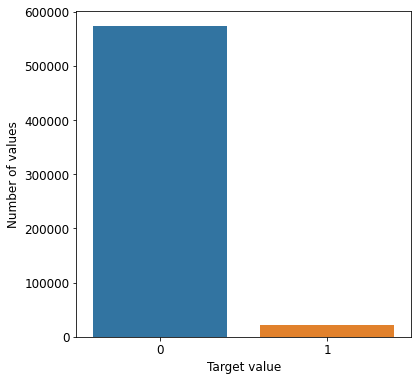

In [18]:
plt.figure()
fig, ax = plt.subplots(figsize=(6, 6))
x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values
# Bar plot
# Order the bars descending on target mean
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

오직 3.64%의 타겟 데이터가 1을 가지고 있습니다. 이는 트레이닝 데이터셋이 매우 불균형하다는 것을 의미합니다. 우리는 target=0으로 undersample을 하거나 target=1으로 oversample을 할 수 있습니다. 데이터셋이 크기 때문에 terget=0을 기준으로 undersampling을 하겠습니다.

### Rea feature

In [19]:
variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [20]:
pow(2, 3)

8

In [21]:
trainset['ps_car_12'].head(5)

0    0.400000
1    0.316228
2    0.316228
3    0.374166
4    0.316070
Name: ps_car_12, dtype: float64

In [22]:
(0.316228*10)**2

10.0000147984

In [23]:
(pow(trainset['ps_car_12']*10, 2)).head(10) # 10을 곱한 뒤 제곱을 해줌

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [24]:
(pow(trainset['ps_car_15'], 2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

**Feature with missing values**  
`ps_reg03`, `pd_car_12`, `ps_car_14`는 결측치를 가지고 있습니다. (최소값이 -1)

**Registration features**  
`ps_reg_01`, `ps_reg_02`는 분모가 10인 분수입니다. (0.1, 0.2, 0.3과 같은 것들)

**Car features**  
`ps_car_12`는 (근사했을 때) 자연수의 제곱근이며 `ps_car_15` 또한 자연수의 제곱근입니다. pair plot을 이용해 값들을 살펴봅시다.

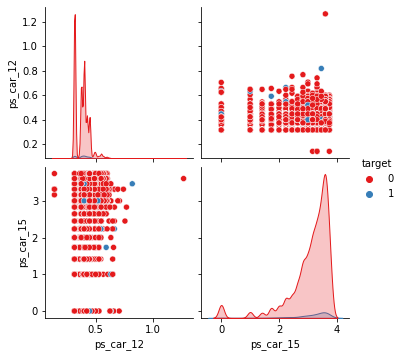

In [25]:
sample = trainset.sample(frac=0.05) # 0.05의 비율을 취함
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

**Calculated features**  
`ps_calc_01`, `ps_calc_02`, `pc_calc_03`은 매우 비슷한 분포를 띄며 어떤 비율인 듯 합니다. 왜냐하면 이들 모두 최대값이 0.9이기 때문입니다. 다른 calculated 값은 최대값이 정수입니다. (5, 6, 7, 10, 12)

실수 피처의 분포를 density plot을 이용해 시각화 해봅시다.

In [26]:
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
len(var)

10

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor 

<Figure size 432x288 with 0 Axes>

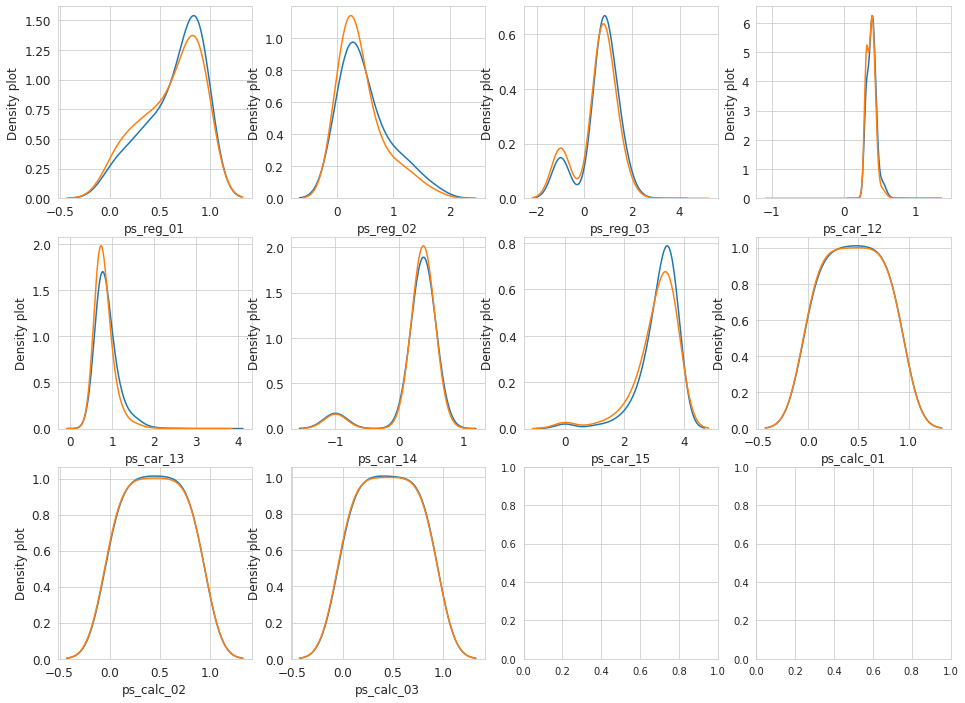

In [27]:
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3,4,figsize=(16,12))

for feature in var:
  i += 1
  plt.subplot(3,4,i)
  sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
  sns.kdeplot(t0[feature], bw=0.5, label="target = 0")
  plt.ylabel('Density plot', fontsize=12)
  plt.xlabel(feature, fontsize=12)
  locs, labels = plt.xticks()
  plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

`ps_reg_02`, `ps_car_13`, `ps_car_15`는 제일 다른 분포를 보여줍니다. target=0, target=1과 연관된 값의 집합들 사이에서

실수 피처들 간의 상관관계를 시각화해 봅시다.

In [28]:
def corr_heatmap(var):
  correlations = trainset[var].corr()

  # Create color map ranging between two colors
  cmap = sns.diverging_palette(50, 10, as_cmap=True)

  fig, ax = plt.subplots(figsize=(10, 10))
  sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f', square=True,
                    linewidths=.5, annot=True, cbar_kws={"shrink": .75})
  plt.show();

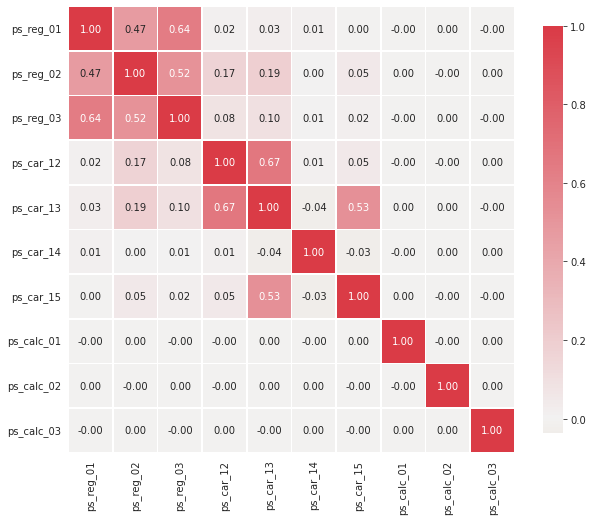

In [29]:
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
corr_heatmap(var)

상관관계가 강한 변수들입니다. 이들을 시각화합시다.
* ps_reg_01 with ps_reg_02 (0.47);
* ps_reg_01 with ps_reg_03 (0.64);
* ps_reg_02 with ps_reg_03 (0.52);
* ps_car_12 with ps_car_13 (0.67);
* ps_car_13 with ps_car_15 (0.53);  
상관관계가 있는 값들의 쌍을 보여주기 위해 pairplot을 쓸 것입니다. pairs를 시각화하기 전에 sample의 2%를 사용해 subsample을 합니다.

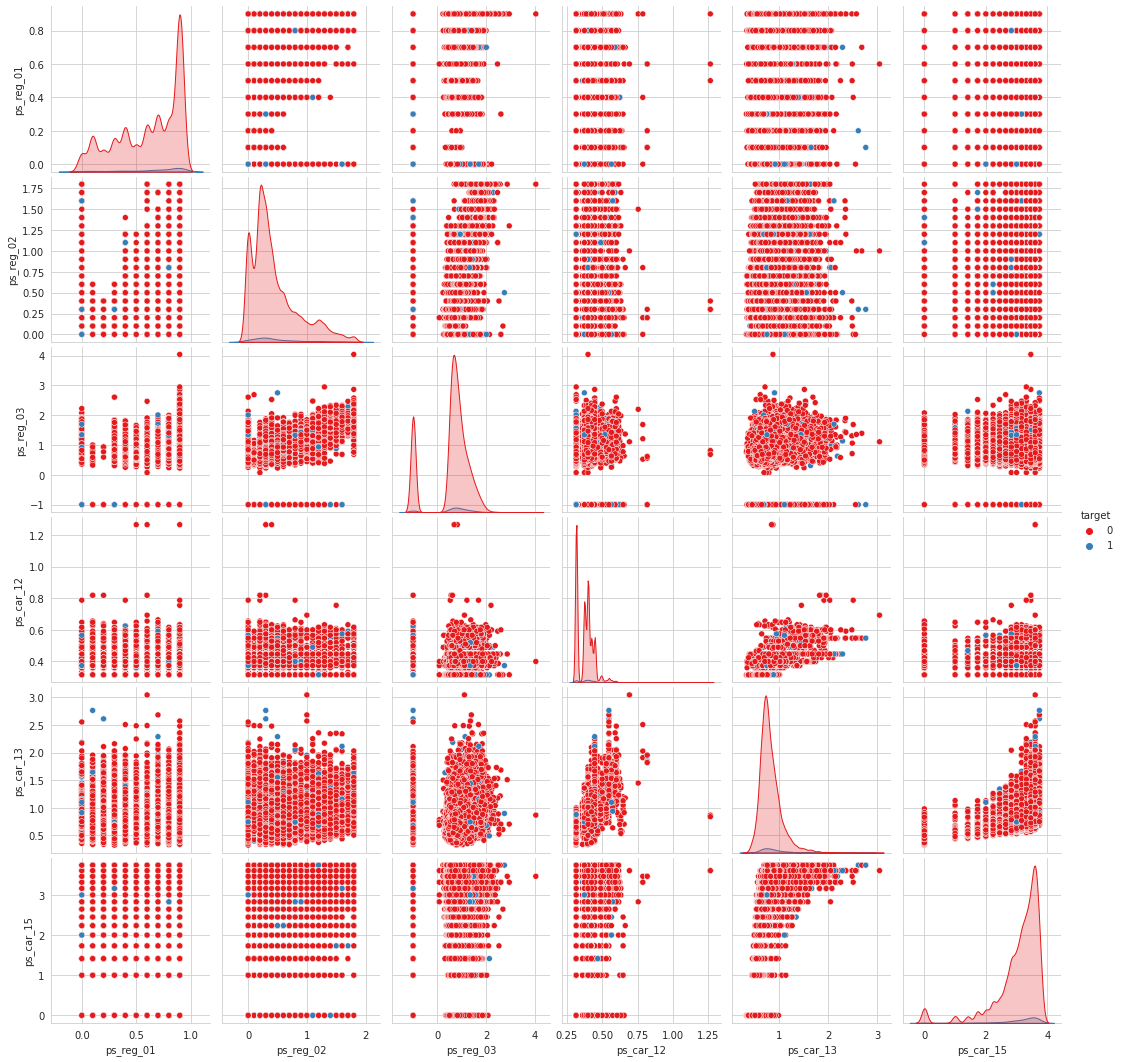

In [30]:
sample = trainset.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]

sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

### Binary features

In [31]:
v = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
trainset[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


트레이닝 데이터셋에 있는 binary 데이터를 시각화해 봅시다. `blue`는 0의 퍼센트를 나타내며 `red`는 1의 퍼센트를 나타냅니다.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x7fd5ee3abe50> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


<Figure size 432x288 with 0 Axes>

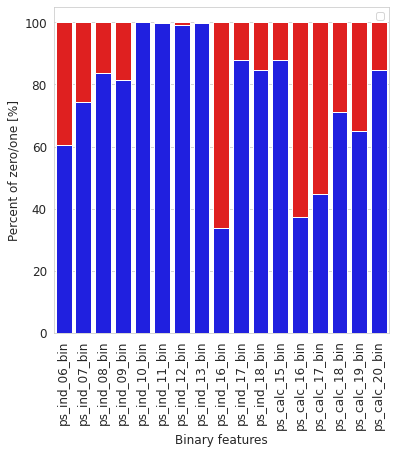

In [32]:
bin_col = [col for col in trainset.columns if '_bin' in col]
zero_list = []
one_list = []

for col in bin_col:
  zero_list.append((trainset[col]==0).sum()/trainset.shape[0]*100)
  one_list.append((trainset[col]==1).sum()/trainset.shape[0]*100)
  
plt.figure()
fig, ax = plt.subplots(figsize=(6, 6))

# Barplot
p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color="blue")
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, bottom=zero_list, color="red")
plt.ylabel('Percent of zero/one [%]', fontsize=12)
plt.xlabel('Binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1, p2), ('Zero', 'One'))
plt.show();

**ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin**은 1값의 숫자가 매우 적습니다(0.5보다 작음). 하지만 1값의 숫자가 매우 큰 값들도 있습니다. **ps_ind_16_bin, ps_cals_16_bin**(60%보다 많음).  
  
이진 데이터의 분포와 target 변수에 해당하는 값들을 확인해 봅시다.

In [33]:
var = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
len(var)

18

In [34]:
var = [col for col in trainset.columns if '_bin' in col]
len(var)

17

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor 

<Figure size 432x288 with 0 Axes>

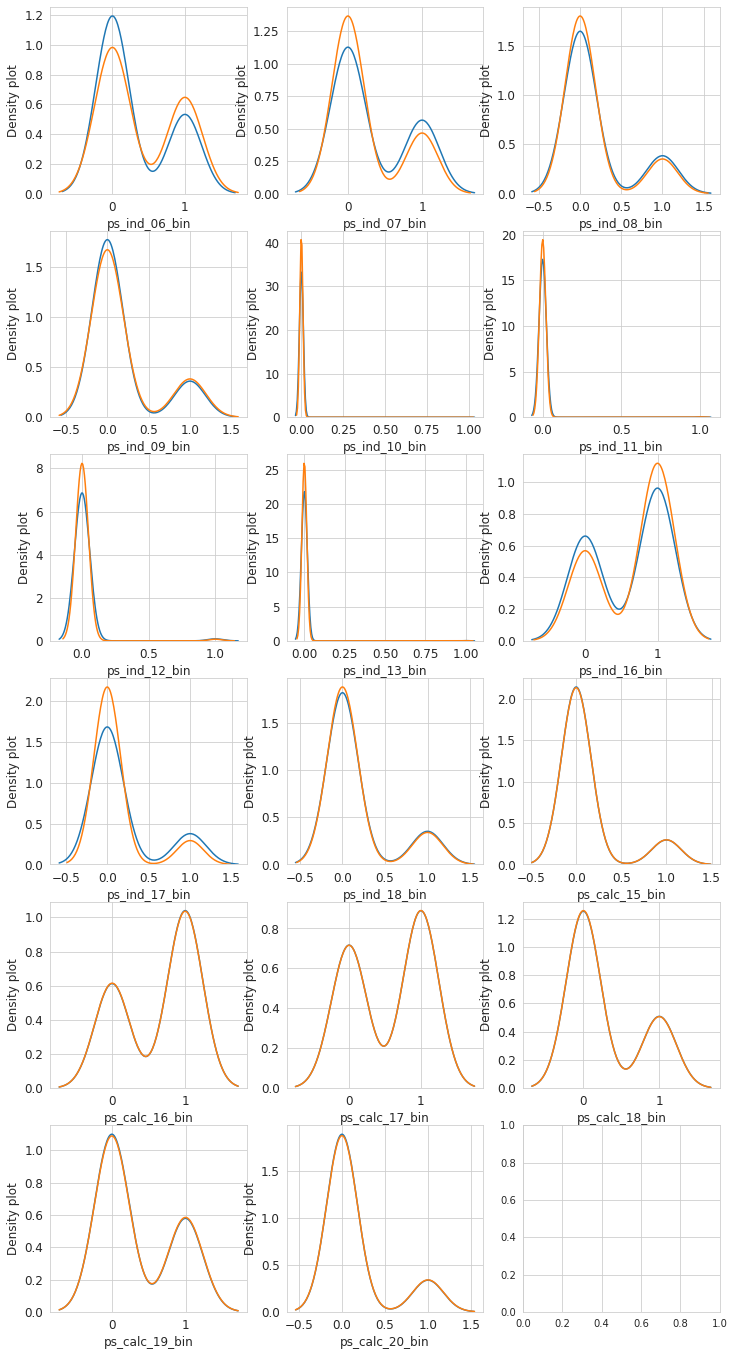

In [35]:
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6, 3, figsize=(12, 24))

for feature in var:
  i += 1
  plt.subplot(6, 3, i)
  sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
  sns.kdeplot(t0[feature], bw=0.5, label="target = 0")
  plt.ylabel('Density plot', fontsize=12)
  plt.xlabel(feature, fontsize=12)
  locs, labels = plt.xticks()
  plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

### Categorical features

두 가지 방식으로 categorical 데이터의 분포를 표현할 것입니다. 첫째, 카테고리 값에 따른 target=1의 비율을 계산한 후 이를 bar plot으로 표현합니다.

In [36]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index
var

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [37]:
trainset[['ps_ind_02_cat', 'target']].groupby(['ps_ind_02_cat'], as_index=False).mean()

,ps_ind_02_cat,target
0,-1,0.185185
1,1,0.035725
2,2,0.038139
3,3,0.037217
4,4,0.040780


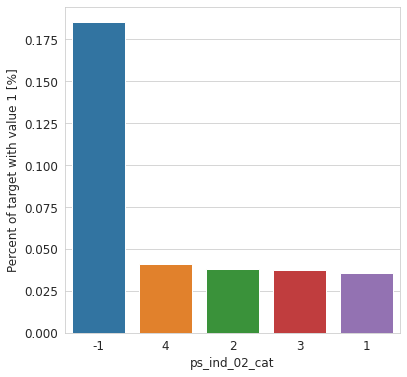

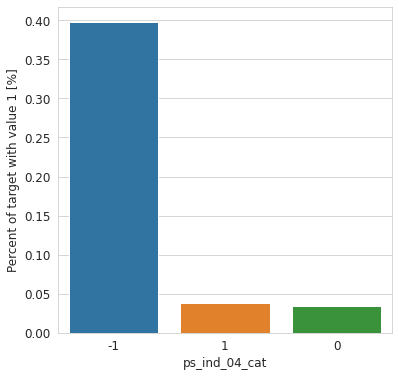

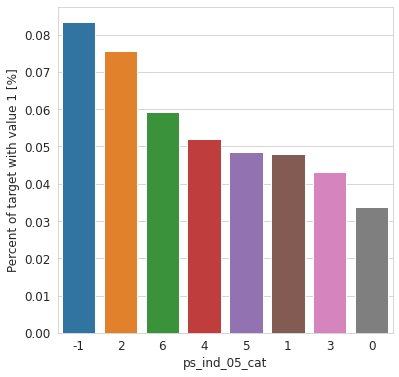

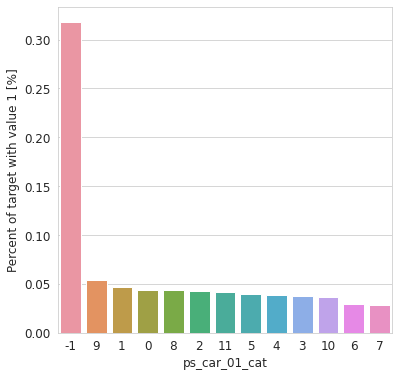

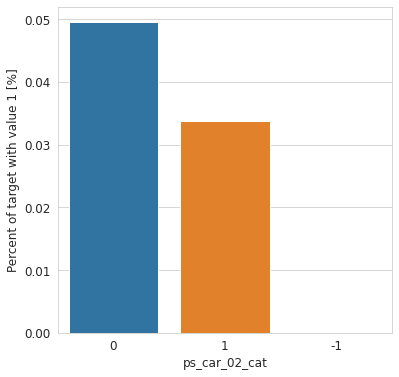

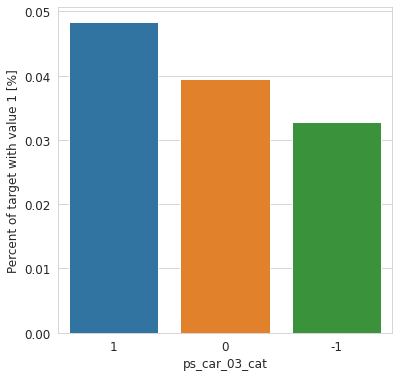

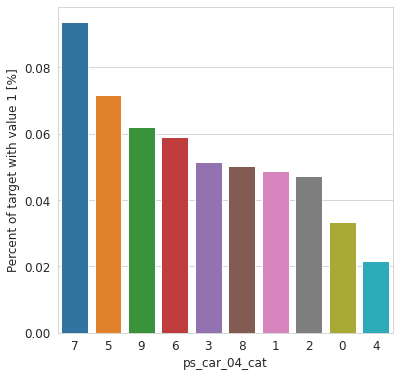

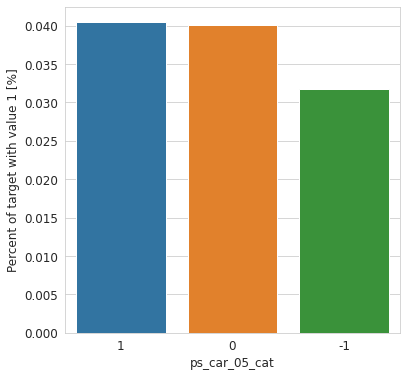

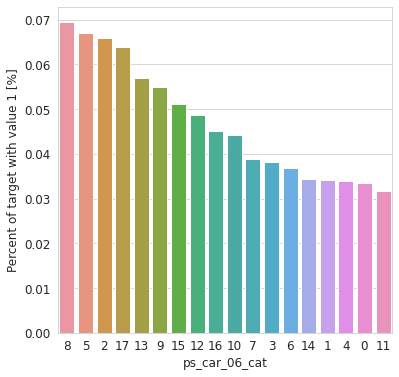

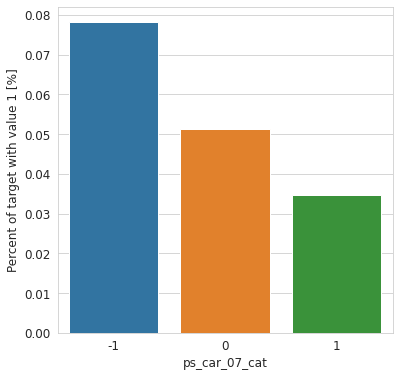

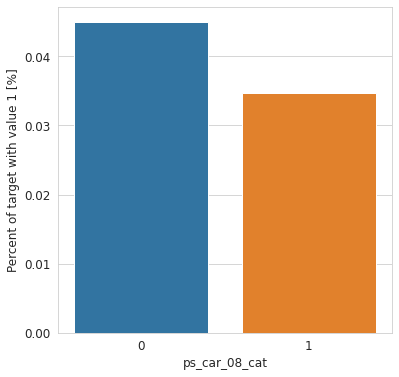

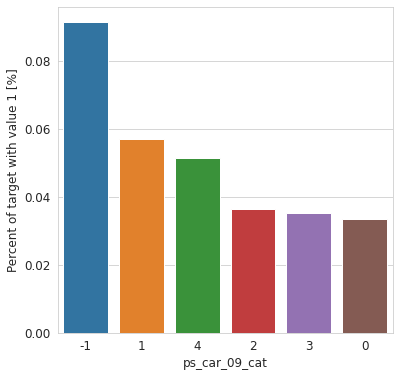

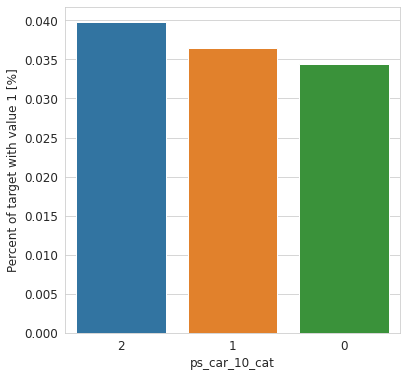

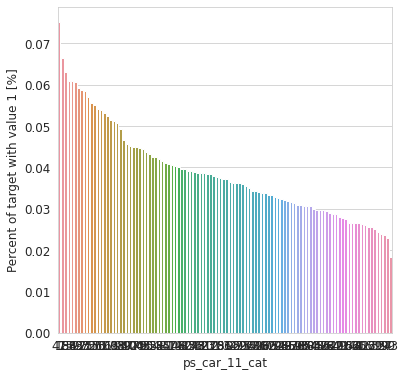

In [38]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

for feature in var:
  fig, ax = plt.subplots(figsize=(6,6))
  # Calculate the percentage of target=1 per category value
  cat_perc = trainset[[feature, 'target']].groupby([feature], as_index=False).mean()
  cat_perc.sort_values(by='target', ascending=False, inplace=True)

  # Bar plot
  # Oder the bars descending on target mean
  sns.barplot(ax=ax, x=feature, y='target', data=cat_perc, order=cat_perc[feature])
  plt.ylabel('Percent of target with value 1 [%]', fontsize=12)
  plt.xlabel(feature, fontsize=12)
  plt.tick_params(axis='both', which='major', labelsize=12)
  plt.show();

대안적으로 범주형 변수들을 density plot을 사용해 나타냈습니다. target=0과 target=1 값을 선택했으며 두 개의 density plot을 같은 그래픽에 나타냈습니다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor 

<Figure size 432x288 with 0 Axes>

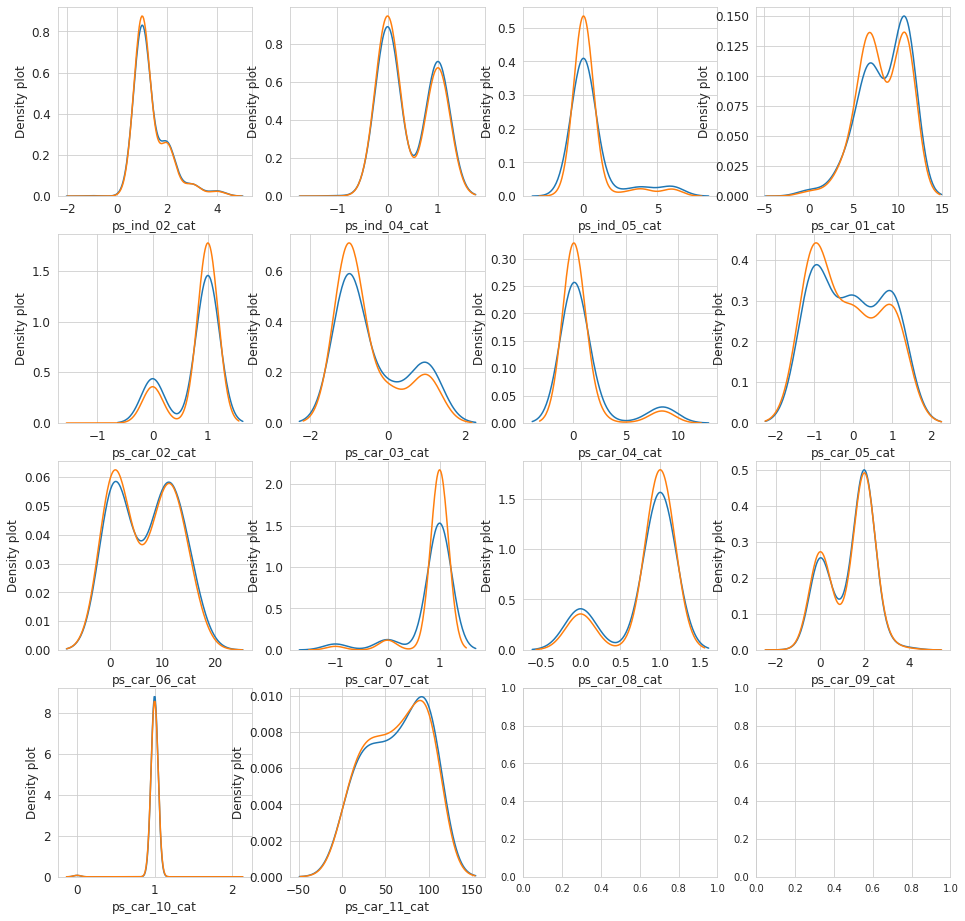

In [39]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(16, 16))

for feature in var:
  i += 1
  plt.subplot(4,4,i)
  sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
  sns.kdeplot(t0[feature], bw=0.5, label="target = 0")
  plt.ylabel('Density plot', fontsize=12)
  plt.xlabel(feature, fontsize=12)
  locs, labels = plt.xticks()
  plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

**ps_car_03_cat, ps_car_05_cat**은 target=0, target=1과 연관된 값들 사이의 분포가 매우 다릅니다.

### Data unbalance between train and test data

train, test 데이터셋 간의 피처 분포를 비교해 봅시다.  
  
`reg`나 `registration` 피처를 먼저 봅시다.

In [40]:
var = metadata[(metadata.category == 'registration') & (metadata.preserve)].index
var

Index(['ps_reg_01', 'ps_reg_02', 'ps_reg_03'], dtype='object', name='varname')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor 

<Figure size 432x288 with 0 Axes>

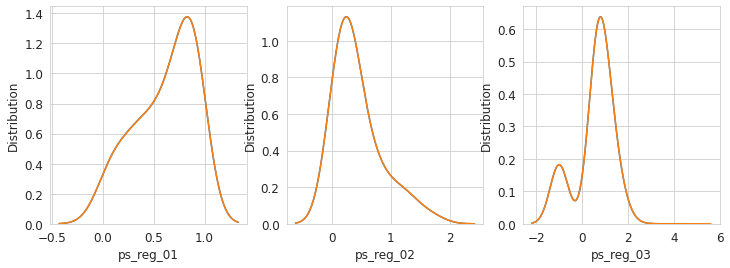

In [41]:
# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(1,3,figsize=(12,4))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(1,3,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor 

<Figure size 432x288 with 0 Axes>

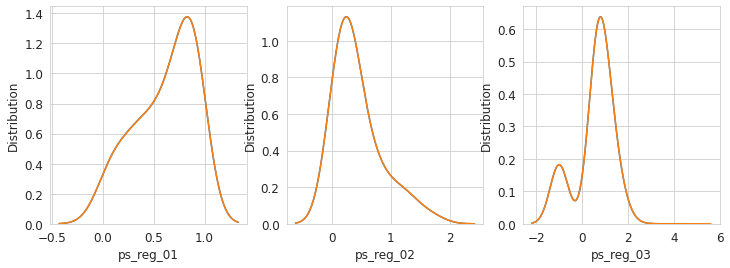

In [42]:
# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
i = 0
for feature in var:
  i = i + 1
  plt.subplot(1, 3, i)
  sns.kdeplot(trainset[feature], bw=0.5, label="train")
  sns.kdeplot(testset[feature], bw=0.5, label="test")
  plt.ylabel('Distribution', fontsize=12)
  plt.xlabel(feature, fontsize=12)
  locs, labels = plt.xticks()

  plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

모든 `reg` 피처는 train, test 셋이 잘 균형을 이루는 것을 보여줍니다.  
  
`car` 피처에 대해서 계속 합니다.

In [43]:
var = metadata[(metadata.category == 'car') & (metadata.preserve)].index
var

Index(['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15'],
      dtype='object', name='varname')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor 

<Figure size 432x288 with 0 Axes>

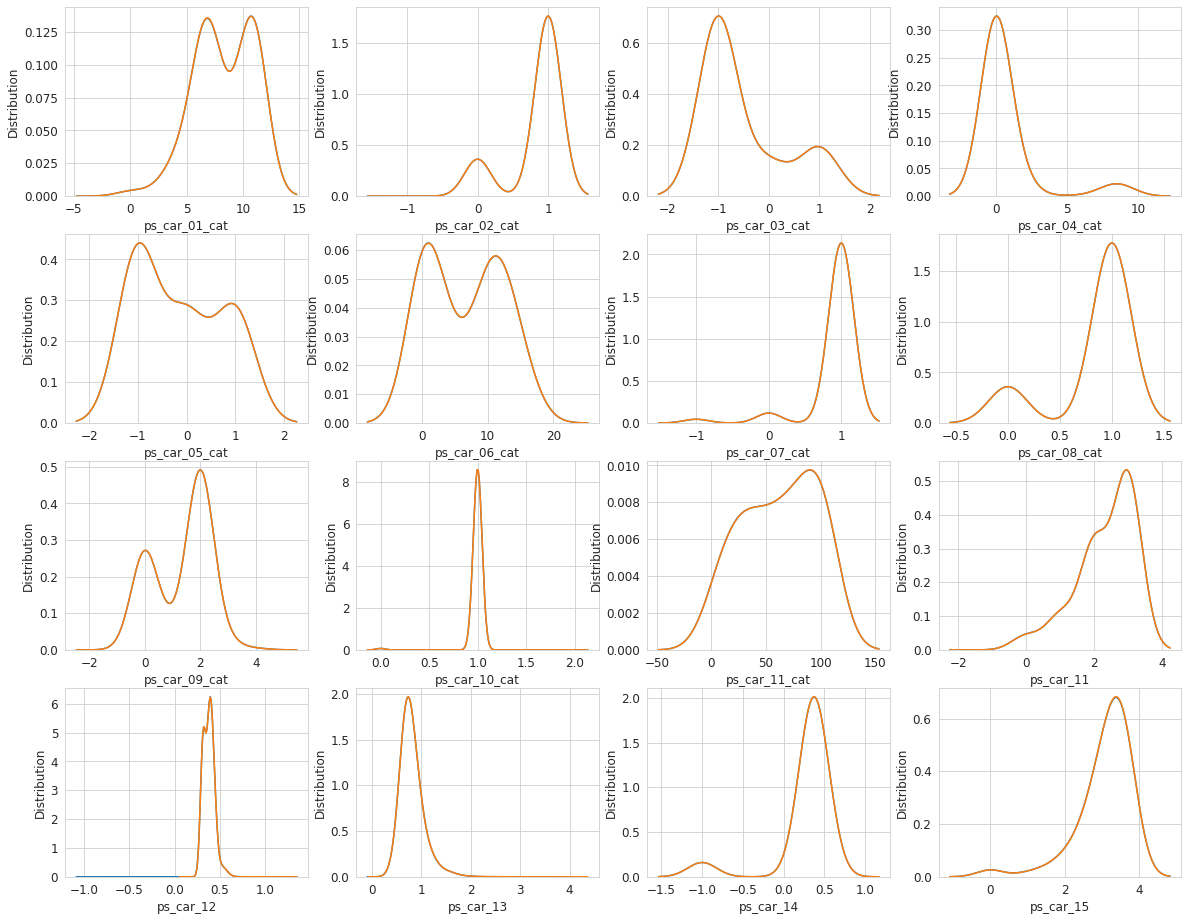

In [44]:
# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(20, 16))
i = 0
for feature in var:
  i = i + 1
  plt.subplot(4, 4, i)
  sns.kdeplot(trainset[feature], bw=0.5, label="train")
  sns.kdeplot(testset[feature], bw=0.5, label="test")
  plt.ylabel('Distribution', fontsize=12)
  plt.xlabel(feature, fontsize=12)
  locs, labels = plt.xticks()

  plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

`car` 피처의 경우 train, test 셋에서 모든 변수의 균형이 잘 맞는듯 합니다.  
  
`ind`(individual) 값에 대해서 봅시다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor 

<Figure size 432x288 with 0 Axes>

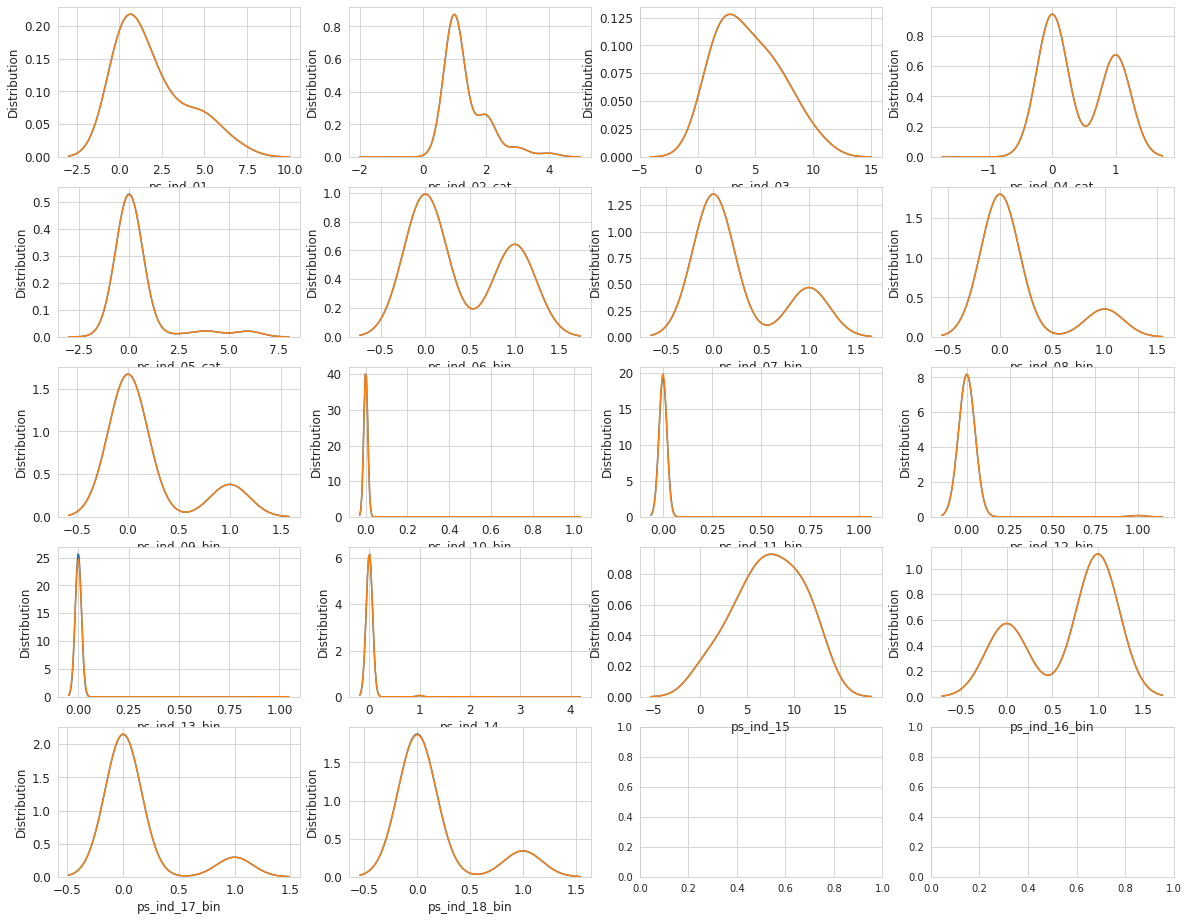

In [45]:
var = metadata[(metadata.category == 'individual') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(5,4,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

`ind` 또한 tarin, test셋이 잘 분포됐습니다.  
  
`calc`에 대해서 살펴봅시다.

In [46]:
var = metadata[(metadata.category == 'calculated') & (metadata.preserve)].index
len(var)

20

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor 

<Figure size 432x288 with 0 Axes>

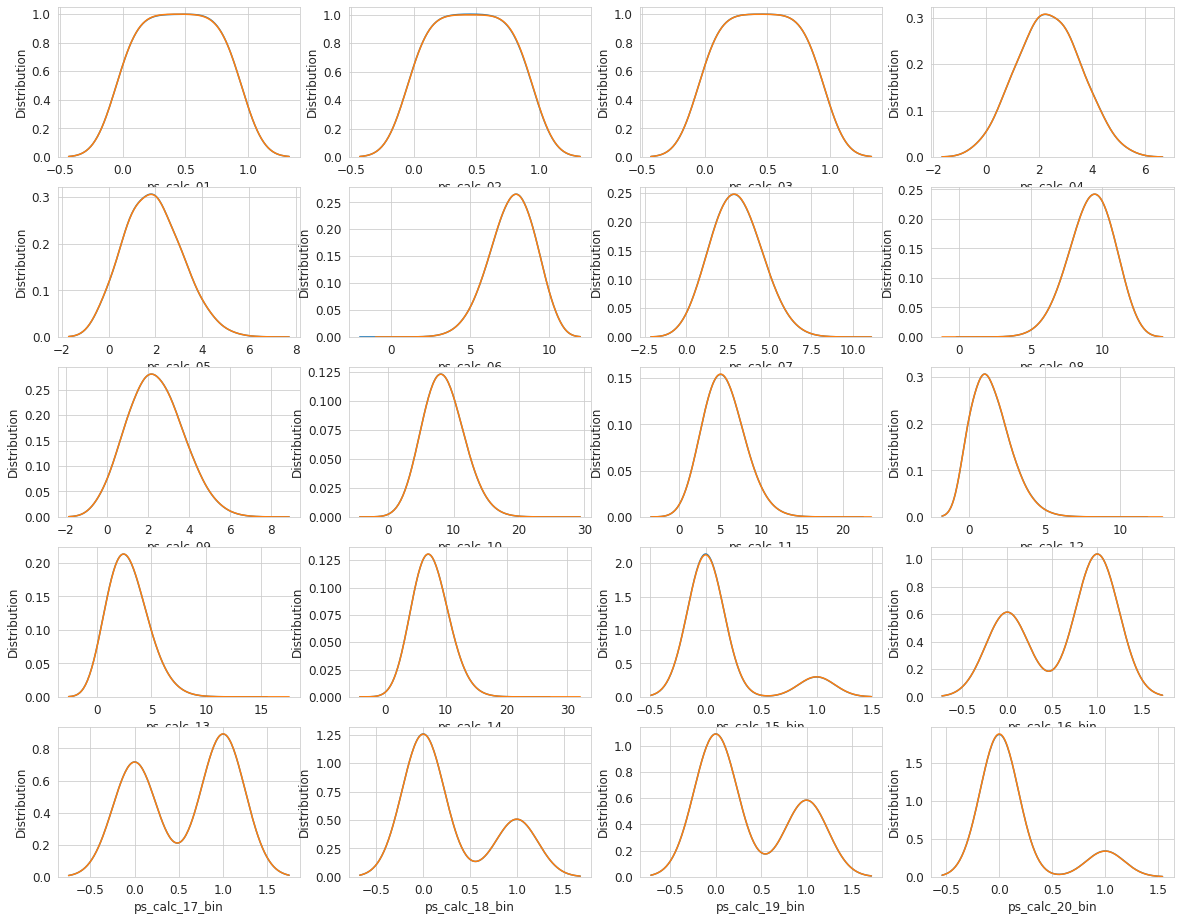

In [47]:
# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(5,4,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

모든 `calc` 피처는 train, test가 잘 분포됐습니다.  

## Check data quality

결측치가 있는 피처들을 살펴봅시다.

In [48]:
vars_with_missing = []

for feature in trainset.columns:
  missings = trainset[trainset[feature] == -1][feature].count()
  if missings > 0:
    vars_with_missing.append(feature)
    missings_perc = missings/trainset.shape[0] # 전체 데이터에서 결측치가 차지하는 비율

    print('Variable {} has {} records ({:.2%}) with missing values'.format(feature, missings, missings_perc))

    print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
In total, there are 1 variables with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
In total, there are 2 variables with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
In total, there are 3 variables with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
In total, there are 4 variables with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
In total, there are 5 variables with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
In total, there are 6 variables with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
In total, there are 7 variables with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
In total, there are 8 variables with missing values
Variable ps_car_07_cat has 11489 records (

## Prepare the data for model

**drop calc columns**  
**calc** 컬럼을 제거합니다. 이들은 가공된 것으로 보이기 때문이며 다른 대회 참가자를 봤을 때 그의 CV score가 이를 제거햇다고 하더라도 향상되었기 때문입니다.

In [49]:
col_to_drop = trainset.columns[trainset.columns.str.startswith('ps_calc_')]
col_to_drop

Index(['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05',
       'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10',
       'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],
      dtype='object')

In [50]:
trainset = trainset.drop(col_to_drop, axis=1)
testset = testset.drop(col_to_drop, axis=1)

**Drop variables with too many missing values**  
결측치가 많은 `ps_car_03_cat`, 그리고 `ps_car_05_cat`을 제거하겠습니다.

In [51]:
# Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
trainset.drop(vars_to_drop, inplace=True, axis=1)
testset.drop(vars_to_drop, inplace=True, axis=1)
metadata.loc[(vars_to_drop), 'keep'] = False # Updating the meta

In [52]:
# data leakage로 인한 add noise, smoothing 코드

# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

**Replaces ps_car_11_cat with encoded value**  
**target_encode** 함수를 이용해 train, test 데이터 셋에 있는 `ps_car_11_cat`을 인코딩된 값으로 대체하겠습니다.

In [53]:
train_encoded, test_encoded = target_encode(trainset["ps_car_11_cat"], testset["ps_car_11_cat"],
                                                                    target=trainset.target,
                                                                    min_samples_leaf=100,
                                                                    smoothing=10,
                                                                    noise_level=0.01)

trainset['ps_car_11_cat_te'] = train_encoded
trainset.drop('ps_car_11_cat', axis=1, inplace=True)
metadata.loc['ps_car_11_cat', 'keep'] = False # Updating the metadata

testset['ps_car_11_cat_te'] = test_encoded
testset.drop('ps_car_11_cat', axis=1, inplace=True)

**Balance target variable**  
타겟 값은 매우 불균형합니다. 이는 target=0을 기준으로 undersampling, 혹은 target=1을 기준으로 oversapling해 개선할 수 있습니다. 트레이닝 데이터셋이 크기 때문에 undersampling을 진행하겠습니다.

In [54]:
# Get the indices per target value
idx_0 = trainset[trainset.target == 0].index
idx_1 = trainset[trainset.target == 1].index

# Get original number of records per target value
nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

In [55]:
print('length a number of target=0', nb_0)
print('length a number of target=1', nb_1)
print('ratio a number of target=0', (nb_0/(nb_0+nb_1))*100,"%")
print('ratio a number of target=1', (nb_1/(nb_0+nb_1))*100,"%")

length a number of target=0 573518
length a number of target=1 21694
ratio a number of target=0 96.3552482140817 %
ratio a number of target=1 3.6447517859182947 %


In [56]:
desired_apriori=0.10

# Calculate the undersampling rete and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


In [57]:
# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=314, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
trainset = trainset.loc[idx_list].reset_index(drop=True)

**Replace -1 values with NaN**  
우리가 사용하려는 대부분의 분류기는 결측치를 다루는데 꽤 좋은 구조를 가지고 있습니다.

In [58]:
trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

**Dummify cat values**  
범주형 피처를 더미 변수로 바꾸겠습니다.

In [59]:
cat_features = [a for a in trainset.columns if a.endswith('cat')]
cat_features

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_04_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat']

In [60]:
pd.get_dummies(pd.Series(trainset['ps_ind_02_cat']))

,1.0,2.0,3.0,4.0
0,0,1,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
216935,1,0,0,0
216936,1,0,0,0
216937,1,0,0,0
216938,0,1,0,0


In [61]:
cat_features = [a for a in trainset.columns if a.endswith('cat')]

for column in cat_features:
  temp = pd.get_dummies(pd.Series(trainset[column]))
  trainset = pd.concat([trainset, temp], axis=1)
  trainset = trainset.drop([column], axis=1)

for column in cat_features:
  temp = pd.get_dummies(pd.Series(testset[column]))
  testset = pd.concat([testset, temp], axis=1)
  testset = testset.drop([column], axis=1)

**Drop unused and target columns**  
id와 target을 따로 분리하고 기존 데이터셋에서 제거하겠습니다.

In [62]:
id_test = testset['id'].values
target_train = trainset['target'].values

trainset = trainset.drop(['target', 'id'], axis=1)
testset = testset.drop(['id'], axis=1)

이제 training, test셋에 대해서 살펴보겠습니다.

In [63]:
print("Train dataset (rows, cols):", trainset.values.shape, "\n Test dataset(rows, cols): ", testset.values.shape)

Train dataset (rows, cols): (216940, 91) 
 Test dataset(rows, cols):  (892816, 91)


## Prepare the model

###Ensamble class for cross validation and ensamble

Kfolds로 데이터를 분리해서 앙상블 클래스를 준비하고, 모델을 훈련시킨 다음 결과를 앙상블합니다.  
  
클래스는 `init`이라는 메서드를 가지고 있는데 (앙상블 object가 만들어질 때 호출됩니다.) 다음과 같은 4개의 파라미터를 가집니다.  
  
* self: 초기화되는 오브젝트입니다.
* n_splits: 사용될 cross-validation의 분할 수입니다.
* stacker: 결과 예측을 stacking하는데 사용될 모델입니다. 훈련된 base models를 사용합니다.
* base_model: training에 사용될 base 모델의 리스트입니다.

두 번째 메서드 `fit_predict`는 4개의 함수를 가집니다.  
  
* training 데이터를 `n_splits` folds에 따라 분리합니다.  
* base model을 각각의 fold에 따라 돌립니다.
* 각각의 모델을 사용해 예측을 수행합니다.
* `stacker`을 이용해 결과를 앙상블합니다.

In [64]:
trainset

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_car_11_cat_te,1.0,2.0,3.0,4.0,0.0,1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,0.0,1.0,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,0.0,1.0,0,1,0.0,1.0,2.0,3.0,4.0,0,1,2
0,1,4,0,1,0,0,0,1,0,0,1,0,0,0,1,0.9,0.2,0.436606,3.0,0.316228,0.662140,0.301662,3.162278,0.028929,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0
1,6,4,0,0,0,1,0,0,0,0,0,8,1,0,0,0.7,0.1,0.520817,2.0,0.400000,0.842750,0.401373,3.316625,0.027193,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0
2,5,9,0,0,1,0,0,0,0,0,0,10,0,0,0,0.8,1.3,1.462660,3.0,0.400000,0.716655,0.330908,2.645751,0.030741,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0
3,0,9,0,1,0,0,0,0,0,0,0,10,0,0,0,0.3,0.0,NaN,2.0,0.447214,1.108756,0.325576,3.464102,0.042625,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0
4,0,10,0,0,0,1,0,0,0,0,0,10,0,0,0,0.7,0.2,0.692369,2.0,0.500000,0.928075,0.383275,2.828427,0.044719,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216935,5,7,0,0,1,0,0,0,0,0,0,8,0,1,0,0.6,0.4,1.537652,1.0,0.424264,1.269111,0.384708,3.162278,0.044687,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0
216936,1,5,0,0,1,0,0,0,0,0,0,4,0,0,1,0.3,0.4,NaN,2.0,0.424264,0.756979,0.400000,2.000000,0.041699,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0
216937,0,6,0,1,0,0,0,0,0,0,0,9,0,1,0,0.9,0.3,0.711952,3.0,0.400000,0.970654,0.372424,3.464102,0.045354,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0
216938,0,2,1,0,0,0,0,0,0,0,0,2,0,0,1,0.6,0.1,0.577170,2.0,0.316228,0.876295,0.320780,3.741657,0.045198,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0


In [65]:
np.array(trainset)

array([[1., 4., 0., ..., 0., 1., 0.],
       [6., 4., 0., ..., 0., 1., 0.],
       [5., 9., 0., ..., 0., 1., 0.],
       ...,
       [0., 6., 0., ..., 0., 1., 0.],
       [0., 2., 1., ..., 0., 1., 0.],
       [1., 1., 0., ..., 0., 1., 0.]])

In [67]:
list(StratifiedKFold(n_splits=3, shuffle=True, random_state=314).split(np.array(trainset), np.array(target_train)))

[(array([     0,      1,      3, ..., 216934, 216936, 216939]),
  array([     2,      4,      8, ..., 216935, 216937, 216938])),
 (array([     0,      1,      2, ..., 216937, 216938, 216939]),
  array([     3,      6,      9, ..., 216921, 216923, 216927])),
 (array([     2,      3,      4, ..., 216935, 216937, 216938]),
  array([     0,      1,      5, ..., 216934, 216936, 216939]))]

코드 해석 도움되는 블로그: stratifiedKFold.split(X,y)  
https://swlock.blogspot.com/2019/01/scikit-learn-cross-validation-iterators.html

In [68]:
class Ensemble(object):
  def __init__(self, n_splits, stacker, bese_models):
    self.n_splits = n_splits
    self.stacker = stacker
    self.base_models = base_models

  def fit_predict(self, X, y, T):
    X = np.array(X)
    y = np.array(y)
    T = np.array(T)

    folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=314).split(X, y))

    S_train = np.zeros((X.shape[0], len(self.base_models))) # row: train셋의 row 길이, column: base models의 개수
    S_test = np.zeros((T.shape[0], len(self.base_models))) # row: testset의 row 길이

    for i, clf in enumerate(self.base_models):
      
      S_test_i = np.zeros((T.shape[0], self.n_splits))

      for j, (train_idx, test_Idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]

        print("Base model %d: fit %s model | fold %d" %(i+1, str(clf).split('(')[0], j+1))
        clf.fit(X_train, y_train)
        cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
        print("cross_score [roc-auc]: %.5f [gini]: %.5f" %(cross_score.mean(), 2*cross_score.mean()-1))

        y_pred = clf.predict_proba(X_holdout)[:, 1]

        S_train[test_idx, i] = y_pred
        S_test_i[:, j] = S_test_i.mean(axis=1)
      S_test[:, i] = S_test_i.mean(axis=1)

    results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')

    # Calculate gini factor as 2 * AUC -1
    print("Stacker score [gini]: %.5f" % (2 * results.mean() -1))

    self.stacker.fit(S_train, y)
    res = self.stacker.predict_proba(S_test)[:, 1]
    return res

**Parameters for the base models**  
베이스 모델을 위해 서로 다른 세개의 LightGBM 모델과 하나의 XGM 모델을 준비합니다.  
  
각각의 모델은 데이터를 훈련하는데 사용됩니다. (크로스 밸리데이션과 3개의 폴드를 이용합니다.)

In [73]:
# Light GBM params
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 650
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8
lgb_params1['min_child_samples'] = 500
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4

# lgb2
lgb_params2 = {}
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['sum_leaves'] = 16
lgb_params2['seed'] = 314
lgb_params2['num_threads'] = 4

# lgb3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4

# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary: logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = -1

LightGBM의 파라미터 `application`은 회귀분석 문제인지, 분류 문제인지를 정한다. (default: regression)
* regression: 회귀분석
* binary: 이진분류
* multiclass: 다중분류  
의문점: 왜 여기서는 apllication을 binary로 바꾸지 않았는지?

LightGBM 지표 파라미터  
* mae: mean absolute error
* mse: mean squared erroe
* binary logloss: loss for binary classification
* multi_logloss: loss for multi classification  
  
여기서도 지표 설정을 해주어야 하는 것 같음.